# PUI Extra Credit Project

Author: Zoe Martiniak (zem232), NYU

Data accessed December 13, 2018

In [70]:
import requests
import os
import sys
import urllib
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point
import pylab as pl
import matplotlib as plt
import datetime
from datetime import datetime
# import Rtree
from geopandas.tools import sjoin
%pylab inline
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
## Downloading NYC Registered Business Data (NYC Open Data)
url = 'https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv?accessType=DOWNLOAD'
filename = 'NYCbusinesses.csv'
! rm 'NYCbusinesses.csv'
! rm $PUIDATA/*NYCbusinesses.csv*
urllib.request.urlretrieve(url,filename)
! mv 'NYCbusinesses.csv' $PUIDATA

rm: NYCbusinesses.csv: No such file or directory
rm: /Users/zoemartiniak/Documents/NYU/PUI/PUI2018/PUIdata/*NYCbusinesses.csv*: No such file or directory


In [3]:
## Downloading Avg. Monthly Neighborhood Rental Prices (Zillow)
url = 'http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_Zri_AllHomesPlusMultifamily.csv'
filename = 'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
! rm 'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
! rm $PUIDATA/'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
urllib.request.urlretrieve(url,filename)
! mv 'Neighborhood_Zri_AllHomesPlusMultifamily.csv' $PUIDATA

rm: cannot remove 'Neighborhood_Zri_AllHomesPlusMultifamily.csv': No such file or directory


In [4]:
## Downloading Zillow Shapefiles
! rm 'ZillowNeighborhoods-NY.zip'
! rm $PUIDATA/*ZillowNeighborhoods-NY*
url = 'https://www.zillowstatic.com/static-neighborhood-boundaries/LATEST/static-neighborhood-boundaries/shp/ZillowNeighborhoods-NY.zip'
filename = 'ZillowNeighborhoods-NY.zip'
urllib.request.urlretrieve(url,filename)
! unzip 'ZillowNeighborhoods-NY.zip' -d $PUIDATA


Archive:  ZillowNeighborhoods-NY.zip
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.prj  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.shp  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.shx  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.dbf  


In [16]:
ZILLOW = pd.read_csv(os.getenv('PUIDATA') + '/Neighborhood_Zri_AllHomesPlusMultifamily.csv')
ZILLOW['RegionID'] = ZILLOW['RegionID'].astype(str)
ZILLOW = ZILLOW[ZILLOW['City']=='New York']
ZILLOW.drop(['State','City','Metro','CountyName'],axis=1, inplace=True)


Text(0.5,1,'Monthly Rental Price by Neighborhood')

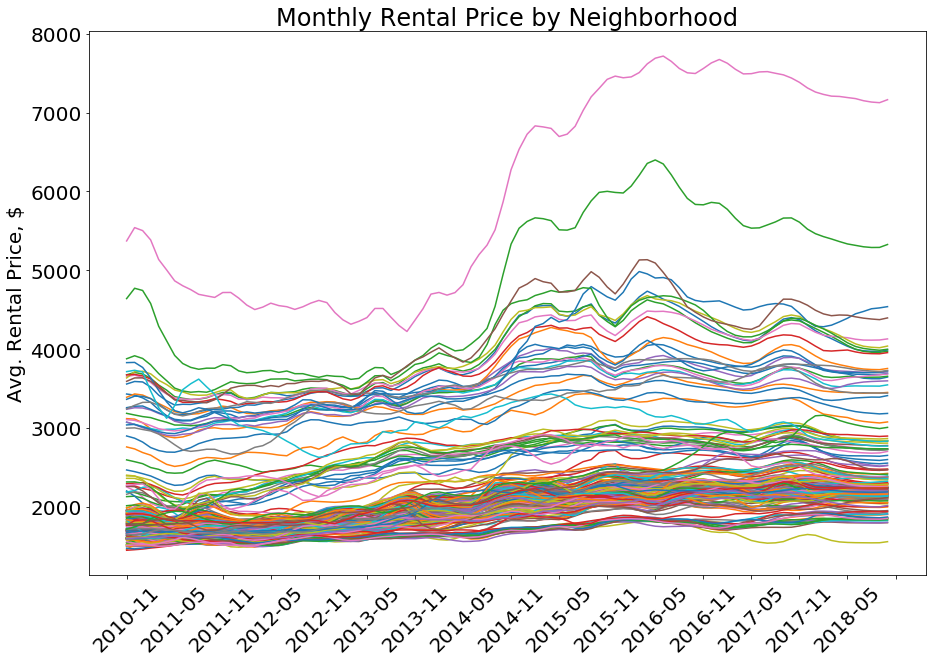

In [17]:
## Plotting Monthly Rental Price by Neighborhood
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[3:]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
for i in ZILLOW.index:
    y = ZILLOW[ZILLOW.index == i].T.values[3:]
    ax.plot(x,y)
pl.rcParams['font.size'] = 20

max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Avg. Rental Price, $')
plt.title('Monthly Rental Price by Neighborhood')


In [18]:
DROPPED = ZILLOW.drop(['RegionID','RegionName','SizeRank'],axis=1).T

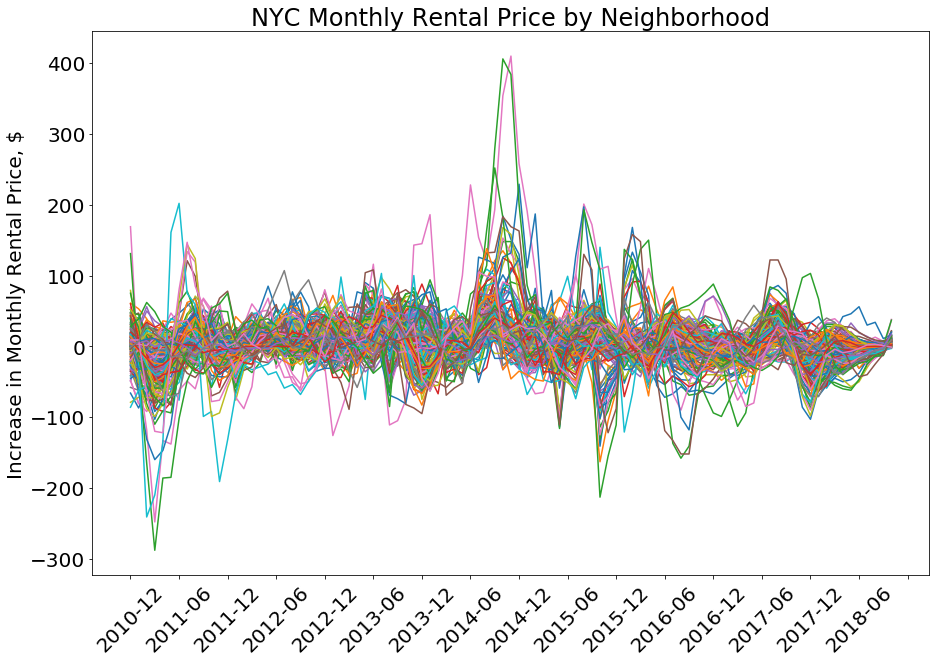

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[4:]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
df = pd.DataFrame(index = ZILLOW.index)
trendmin = []
trendmax = []
for i in ZILLOW.index:
    y= []
    for c in range(1,len(DROPPED.index)):
        y.append(DROPPED[i][DROPPED.index[c]]-DROPPED[i][DROPPED.index[c-1]])
    ax.plot(x,y)
    trendmin.append(min(y))
    trendmax.append(max(y))
df['min'] = trendmin
df['max'] = trendmax
max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Increase in Monthly Rental Price, $')
plt.title('NYC Monthly Rental Price by Neighborhood')
plt.savefig("Period_Detection.jpeg", bbox_inches='tight')


In [20]:
## Unsurprisingly, the neighborhoods with highest peaks also have highest dips
print(df.sort_values('min').head(10))
print(df.sort_values('max', ascending=False).head(10))

        min    max
1349 -288.0  406.0
609  -248.0  410.0
2865 -241.0  202.0
1571 -213.0  252.0
103  -163.0  135.0
873  -160.0  229.0
2678 -152.0  183.0
194  -141.0  184.0
205  -131.0  148.0
427  -125.0  153.0
        min    max
609  -248.0  410.0
1349 -288.0  406.0
1571 -213.0  252.0
873  -160.0  229.0
2865 -241.0  202.0
194  -141.0  184.0
2678 -152.0  183.0
509  -103.0  168.0
427  -125.0  153.0
205  -131.0  148.0


In [21]:
ZILLOW['PERC_INCR'] = (ZILLOW['2018-10']-ZILLOW['2010-11'])/ZILLOW['2010-11']

In [22]:
ZILLOWSHP = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') +'/ZillowNeighborhoods-NY.shp')
ZILLOWSHP = ZILLOWSHP[ZILLOWSHP['City']=='New York']
ZILLOWSHP.drop(['State','City'],axis=1, inplace=True)

In [24]:
ZILLOWSHP = ZILLOWSHP.merge(ZILLOW, on='RegionID')

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


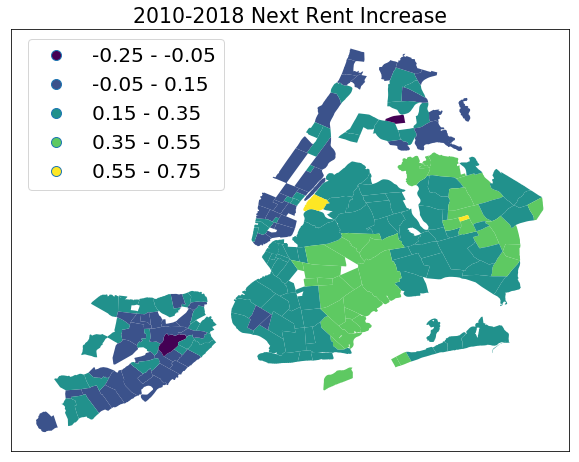

In [25]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ZILLOWSHP.plot(column='PERC_INCR',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, scheme="Equal_interval", legend=True, k=5)
pl.rcParams['font.size'] = 17
plt.title("2010-2018 Next Rent Increase")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0, .8, 0.4, 0.2));
plt.savefig("Rent_Increase.jpeg", bbox_inches='tight')


In [26]:
TOPGEN = ZILLOW.sort_values('PERC_INCR').tail()
TOPGEN

,RegionID,RegionName,SizeRank,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,PERC_INCR
61,193640,Canarsie,62,1451.0,1458.0,1466.0,1479.0,1489.0,1501.0,1517.0,...,2171,2175,2177,2176,2174,2172,2171,2170,2172,0.496899
16,272902,Bedford Stuyvesant,17,1586.0,1583.0,1577.0,1571.0,1566.0,1574.0,1588.0,...,2467,2443,2420,2404,2392,2386,2381,2377,2386,0.504414
24,403222,Crown Heights,25,1546.0,1543.0,1540.0,1536.0,1539.0,1551.0,1566.0,...,2427,2409,2393,2381,2369,2359,2353,2349,2355,0.523286
953,270857,Hunters Point,954,1706.0,1708.0,1703.0,1701.0,1711.0,1734.0,1781.0,...,2756,2737,2718,2704,2693,2686,2682,2685,2704,0.584994
4782,276623,Utopia,4783,1719.0,1747.0,1786.0,1848.0,1897.0,1925.0,1945.0,...,3163,3137,3097,3066,3042,3021,3007,2994,3009,0.750436


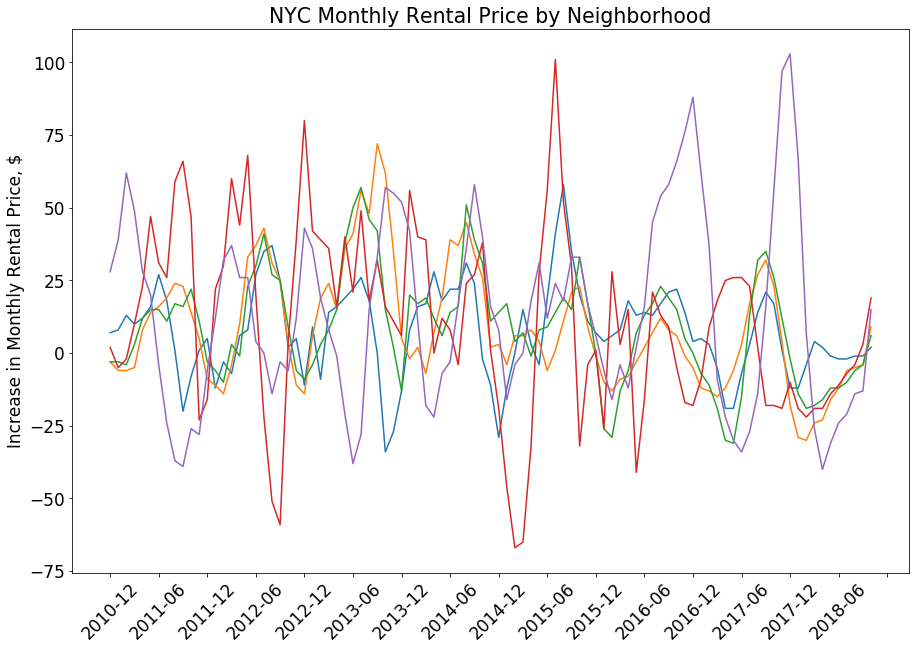

In [30]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[4:-1]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']

for i in TOPGEN.index:
    y= []
    for c in range(1,len(DROPPED.index)):
        y.append(DROPPED[i][DROPPED.index[c]]-DROPPED[i][DROPPED.index[c-1]])
    ax.plot(x,y)

max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Increase in Monthly Rental Price, $')
plt.title('NYC Monthly Rental Price by Neighborhood')
plt.savefig("Top_Gentr_Neighborhoods.jpeg", bbox_inches='tight')

At around the start of 2015 is when the 5 most gentrifying neighborhoods experienced a large peak, therefore we will select 2015.

In [50]:
NYCBIZ = pd.read_csv(os.getenv('PUIDATA') + '/NYCbusinesses.csv')

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
NYCBIZ.dropna(subset=['Business Name'], axis=0,inplace=True)

In [52]:
NYCBIZ = NYCBIZ[NYCBIZ['Latitude']>0]
NYCBIZ = NYCBIZ[NYCBIZ['Longitude']>-75]
NYCBIZ.drop(['DCA License Number','Address Building', 'Address Street Name',
       'Secondary Address Street Name','Address City', 'Address State','Contact Phone Number',
            'Borough Code', 'Community Board', 'Council District', 'BIN', 'BBL'], axis=1, inplace=True)

In [53]:
IND = NYCBIZ['Industry'].unique()

In [54]:
for x in range(len(IND)):
    if len(NYCBIZ[NYCBIZ['Industry'] == IND[x]]) < 800:
        print('Deleting %s (only %i entries))'
              %(IND[x],len(NYCBIZ[NYCBIZ['Industry'] == IND[x]])))
        NYCBIZ = NYCBIZ[NYCBIZ['Industry'] != IND[x]]


Deleting Amusement Device Permanent (only 174 entries))
Deleting Pedicab Business (only 396 entries))
Deleting Cabaret (only 162 entries))
Deleting Games of Chance (only 115 entries))
Deleting Tow Truck Company (only 760 entries))
Deleting Debt Collection Agency (only 300 entries))
Deleting Newsstand (only 374 entries))
Deleting Amusement Device Temporary (only 296 entries))
Deleting Horse Drawn Cab Owner (only 93 entries))
Deleting Employment Agency (only 515 entries))
Deleting Sightseeing Bus (only 23 entries))
Deleting Special Sale (only 182 entries))
Deleting Pawnbroker (only 550 entries))
Deleting Pool or Billiard Room (only 81 entries))
Deleting Amusement Device Portable (only 656 entries))
Deleting Car Wash (only 138 entries))
Deleting Parking Lot (only 644 entries))
Deleting Secondhand Dealer - Firearms (only 8 entries))
Deleting Catering Establishment (only 64 entries))
Deleting Process Serving Agency (only 88 entries))
Deleting Tow Truck Exemption (only 54 entries))
Deleting 

In [55]:
NYCBIZ[NYCBIZ.Industry == 'Tobacco Retail Dealer'].count()

License Type               14676
License Expiration Date    14675
License Status             14676
License Creation Date      14676
Industry                   14676
Business Name              14676
Business Name 2             3257
Address ZIP                14676
Address Borough            14676
NTA                        14042
Census Tract               14042
Detail                         0
Longitude                  14676
Latitude                   14676
Location                   14676
dtype: int64

In [58]:
NYCBIZ.drop(['License Type','Address ZIP', 'Address Borough', 'NTA', 'Census Tract']
           ,axis=1, inplace=True)

In [60]:
gg=[(k, NYCBIZ['Business Name'][k]) for k in NYCBIZ.index if 'GROCER' in NYCBIZ['Business Name'][k] or 'FOOD' in NYCBIZ['Business Name'][k] or 'PRODUCE' in NYCBIZ['Business Name'][k]] 
    #and 'DELI' not in NYCBIZ['Business Name'][k]]
len(gg)


6264

In [65]:
NYCBIZ['License Creation']=pd.to_datetime(NYCBIZ['License Creation Date'])
NYCBIZ['License Expiration'] = pd.to_datetime(NYCBIZ['License Expiration Date'])
NYCBIZ.drop(['License Expiration Date','License Creation Date'],axis=1, inplace=True)


In [83]:
NYCBIZ[(NYCBIZ['License Creation']>datetime(2015,1,1)) & (NYCBIZ['License Status']=='Active')]


,License Status,Industry,Business Name,Business Name 2,Detail,geometry,License Creation,License Expiration
6,Active,Laundries,KANG LE LAUNDROMAT INC,NaN,Sub-License Type: Retail Laundry,POINT (-73.93294011345556 40.61903874185032),2018-10-10,2019-12-31
13,Active,Home Improvement Contractor,MKINNOVATION CONSTRUCTION LLC,NaN,NaN,POINT (-74.09475125855013 40.5698296851936),2015-07-08,2021-02-28
42,Active,Home Improvement Contractor,"SOROHAN CONTRACTING, CORP.",NaN,NaN,POINT (-73.95006061840928 40.782964849066),2017-12-26,2021-02-28
73,Active,Home Improvement Contractor,JOHN J CONSTRUCTION INC,NaN,NaN,POINT (-74.01027020665089 40.64688999358987),2015-07-28,2021-02-28
76,Active,Home Improvement Contractor,"HASAN, MOHAMMAD",NaN,NaN,POINT (-73.98166241079909 40.64312040108853),2017-01-12,2021-02-28
107,Active,Home Improvement Contractor,"YU, HONG ZHU",P & G CONSTRUCTION CO,NaN,POINT (-74.00543387511669 40.64289391760091),2018-06-19,2021-02-28
110,Active,Electronics Store,IMPERIAL WIRELESS INC.,NaN,NaN,POINT (-73.87576944518359 40.82916559332329),2015-12-16,2020-12-31
123,Active,Home Improvement Contractor,P.A.L. ENVIRONMENTAL SAFETY CORP,PAL ENVIRONMENTAL SERVICES,NaN,POINT (-73.94650253455252 40.75312517373874),2017-05-17,2021-02-28
145,Active,Home Improvement Contractor,TRIERA CONTRACTING INC,NaN,NaN,POINT (-73.8026820303628 40.69932218895192),2015-08-27,2021-02-28
160,Active,Electronics Store,MOBILE CITY DISTRICT 1 LLC,Mobile City District 1 LLC,NaN,POINT (-73.95045466390813 40.6804484266835),2018-10-16,2018-12-31


In [61]:
for i in range(len(gg)):
    NYCBIZ['Industry'][gg[i][0]] = 'Grocery'

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [62]:
geometry = [Point(xy) for xy in zip(NYCBIZ.Longitude, NYCBIZ.Latitude)]
crs = {'init':'epsg:4326'}
NYCBIZ = gp.GeoDataFrame(NYCBIZ, crs=crs, geometry=geometry)
NYCBIZ.drop(['Longitude','Latitude','Location'],axis=1,inplace=True)

In [63]:
ZILLOWSHP = ZILLOWSHP.to_crs(epsg=4326)
NYCBIZ = NYCBIZ.to_crs(epsg=4326)

In [ ]:
ZILLOWSHP.crs

In [ ]:
NYCBIZ.crs

In [ ]:
gp.sjoin(ZILLOWSHP,NYCBIZ).groupby(['RegionID'])

In [ ]:
NYCBIZ.head()

pointsin = []
biz = NYCBIZ.copy()
for i, poly in ZILLOWSHP.iterrows():
    pointsinthispoly=[]
    for j, pt in biz.iterrows():
        if poly.geometry.contains(pt.geometry):
            pointsinthispoly.append(pt.geometry)
            biz = biz.drop([j])
    pointsin.append(len(pointsinthispoly))

In [ ]:
f, ax = plt.subplots(1, figsize=(15,15))
#ax.set_axis_off()
plt.axis('equal')
#ZILLOWSHP.plot(ax=ax, column='2018-10',cmap='cool',alpha=1,
                  #linewidth=0.1,scheme="quantiles", legend=True, k=10)
# Plot the linkNYC stations over the chlorpleth
# Stations are color installed, using the date_link column
#### Can't show the legend though, otherwise it overwrites the choropleth legend.. :/
NYCBIZ.plot(markersize=15, ax=ax)
plt.title("Density of LinkNYC Stations Per Capita in PUMA Sectors", fontsize=20);